# Comparative Analysis with MELD

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scprep
import meld
import sklearn
import pickle
import cna
import time

# making sure plots & clusters are reproducible
np.random.seed(42)

# Test on Sepsis

In [5]:
# Import sepsis expression data
d = cna.read('/data/srlab/lrumker/MCSC_Project/sepsis_data/pbmc.h5ad')

In [6]:
sepsis_data = d.to_df() # Cells x genes
sepsis_metadata = d.obs

In [7]:
## Define phenotype of interest as ANY sepsis to match CNA
any_sepsis = np.zeros(sepsis_metadata.shape[0])
any_sepsis[np.where(sepsis_metadata['pheno']=='Bac-SEP')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='ICU-SEP')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='URO')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='Int-URO')[0]] = 1

sepsis_metadata['AnySepsis'] = any_sepsis

In [ ]:
# PCA for dimensionality reduction with default parameters (100 components)
data_pca = scprep.reduce.pca(sepsis_data)

In [ ]:
# Used default MELD parameters
time_a = time.time()
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(data_pca, sample_labels=sepsis_metadata['patient'])
time_b = time.time()
print(time_b-time_a)

In [ ]:
# Save sample densities object
pickle.dump(sample_densities, open( "MELD_sample_densities_sepsis.p", "wb" ) )

In [8]:
# Load saved object
sample_densities = pickle.load( open( "MELD_sample_densities_sepsis.p", "rb" ) )

In [9]:
# Apply row-wise L1 normalization
sample_likelihoods = sample_densities/sample_densities.sum(axis=1)[:,None]

In [10]:
# Identify case sample colums
sepsis_samples = np.unique(sepsis_metadata['patient'][np.where(sepsis_metadata['AnySepsis']==1)[0]])
sepsis_metadata['likelihood_sepsis'] = sample_likelihoods[sepsis_samples].mean(axis=1).values

## Compare per-cell values from MELD and CNA

In [11]:
# Load CNA results
cna_res = pd.read_csv("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsisres.csv")

In [12]:
# Correlation between per-cell values from MELD and CNA
np.corrcoef(cna_res['ncorrs'], sepsis_metadata['likelihood_sepsis'])[0,1]

0.5972022625430764

## Analysis of statistical properties of MELD

In [13]:
# read sepsis data
import cna
d = cna.read('/data/srlab/lrumker/MCSC_Project/sepsis_data/pbmc.h5ad')

sepsis_data = d.to_df() # Cells x genes
sepsis_metadata = d.obs

## Define phenotype of interest as ANY sepsis
any_sepsis = np.zeros(sepsis_metadata.shape[0])
any_sepsis[np.where(sepsis_metadata['pheno']=='Bac-SEP')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='ICU-SEP')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='URO')[0]] = 1
any_sepsis[np.where(sepsis_metadata['pheno']=='Int-URO')[0]] = 1
sepsis_metadata['AnySepsis'] = any_sepsis

/PHShome/lar24/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/PHShome/lar24/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [14]:
# initiatlize sampleXmeta for sepsis
sampleXmeta = sepsis_metadata[['patient', 'AnySepsis']].drop_duplicates().set_index('patient', drop=True)
true_pheno = sampleXmeta.AnySepsis.values.astype(bool)

In [17]:
# obtain memory requirement for storing NAM
cna.tl.nam(d)
d.uns['NAM.T'].values.nbytes / np.power(2, 20)

qcd NAM not found; computing and saving
	taking step 1


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  a = data.uns['neighbors']['connectivities']


	median kurtosis: 25.741362009778367
	taking step 2
	median kurtosis: 17.102439445613538
	taking step 3
	median kurtosis: 12.333806048520458
	taking step 4
	median kurtosis: 10.004299261046336
stopping after 4 steps


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:59: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')


50.98655700683594

In [16]:
res = cna.tl.association(d, true_pheno)

qcd NAM not found; computing and saving
	taking step 1


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  a = data.uns['neighbors']['connectivities']


	median kurtosis: 25.741362009778367
	taking step 2
	median kurtosis: 17.102439445613538
	taking step 3
	median kurtosis: 12.333806048520458
	taking step 4
	median kurtosis: 10.004299261046336
stopping after 4 steps
performing association test


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:59: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')
/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_association.py:71: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


In [18]:
# read MELD sample densities
# path = '/data/srlab/lrumker/MCSC_Project/sepsis_data/sepsis_sample_densities.p'
path = "MELD_sample_densities_sepsis.p"
sample_densities = pickle.load(open(path, 'rb'))
sample_densities /= sample_densities.sum(axis=1)[:,None] # This is termed sample "likelihoods" in the publication

In [19]:
color_scale_threshold = 0.0025

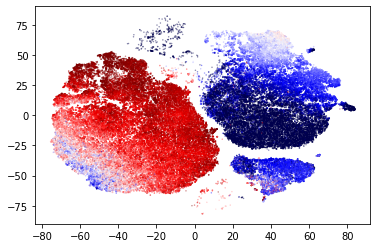

In [20]:
# perform non-null analysis
val = sample_densities[sampleXmeta.index[true_pheno]].mean(axis=1) - sample_densities.mean(axis=1)
plt.scatter(d.obsm['X_tsne'][:,0], d.obsm['X_tsne'][:,1],
           alpha=0.5, c = val, cmap = "seismic", s=0.2, vmin=-color_scale_threshold, vmax=color_scale_threshold)

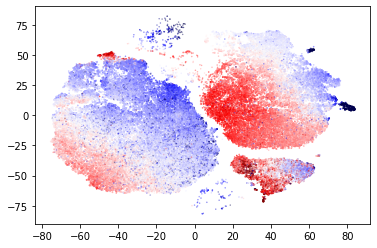

qcd NAM not found; computing and saving
	taking step 1


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:7: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  a = data.uns['neighbors']['connectivities']


	median kurtosis: 25.741362009778367
	taking step 2
	median kurtosis: 17.102439445613538
	taking step 3
	median kurtosis: 12.333806048520458
	taking step 4
	median kurtosis: 10.004299261046336
stopping after 4 steps
performing association test


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_nam.py:59: UserWarning: only one unique batch supplied to qc
  warnings.warn('only one unique batch supplied to qc')


CNA p = 0.07592407592407592


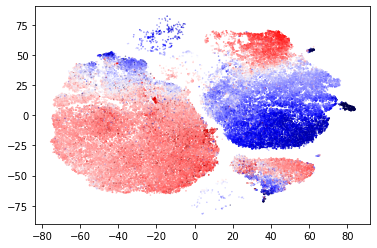

performing association test
CNA p = 0.6403596403596403


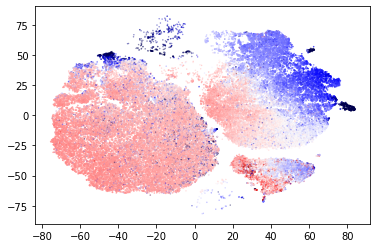

performing association test
CNA p = 0.8301698301698301


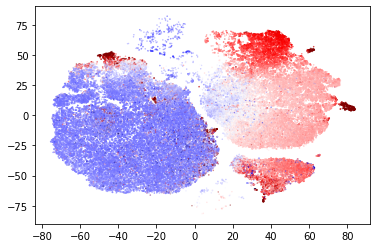

performing association test


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_association.py:55: UserWarning: data supported use of 4 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  'Consider allowing more PCs by using the "ks" argument.').format(k))


CNA p = 0.46853146853146854


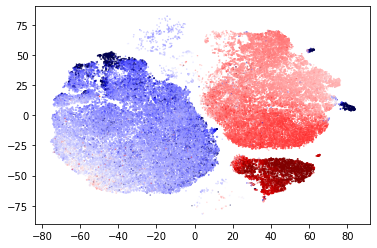

performing association test
CNA p = 0.8311688311688312


In [21]:
# create null phenotype visualizations
np.random.seed(0)
for i in range(5):
    ix = np.argsort(np.random.randn(len(true_pheno)))
    null = true_pheno[ix]
    nullval = sample_densities[sampleXmeta.index[null]].mean(axis=1) - sample_densities.mean(axis=1)
    plt.scatter(d.obsm['X_tsne'][:,0], d.obsm['X_tsne'][:,1],
               alpha=0.5, c=nullval, cmap = "seismic", s=0.2, vmin=-color_scale_threshold, vmax=color_scale_threshold)
    plt.show()
    nullres = cna.tl.association(d, null, local_test=False)
    print('CNA p =', nullres.p)

In [22]:
# compute null distribution for MELD scores
T = 500
null_scores = np.zeros((T, len(sample_densities)))
for i in range(500):
    print('.', end='')
    ix = np.argsort(np.random.randn(len(true_pheno)))
    null = true_pheno[ix]
    null_scores[i] = sample_densities[sampleXmeta.index[null]].mean(axis=1) - sample_densities.mean(axis=1)
null_scores = null_scores.T

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [28]:
# compute FDRs
fdrs = []
thresholds = np.arange(50, 100, 1)
for thresh in np.percentile(np.abs(val), thresholds):
    print('.', end='')
    discoveries = (np.abs(val) >= thresh).sum()
    Efd = (np.abs(null_scores) >= thresh).sum(axis=0).mean()
    fdrs.append(Efd/discoveries)

..................................................

In [24]:
CNA_thresholds = np.array([(np.abs(res.ncorrs) <= t).mean()*100 for t in res.fdrs.threshold])
CNA_fdrs = res.fdrs.fdr.values

Text(0, 0.5, 'FDR')

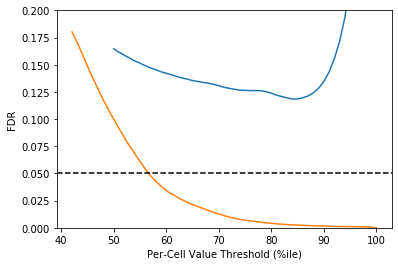

In [25]:
plt.plot(thresholds, fdrs, label='MELD')
plt.plot(CNA_thresholds, CNA_fdrs, label='CNA')
plt.xlabel('Per-Cell Value Threshold (%ile)')
plt.ylim(0,0.2)
plt.axhline(y=0.05, color='k', linestyle='--')
plt.ylabel('FDR')

In [90]:
plot_thresholds = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]

In [91]:
total_cells = d.obs.shape[0]
MELD_cells_passing = []
for t in plot_thresholds:
    if np.min(fdrs)>t:
        MELD_cells_passing.append(0)
    else:
        i_first_below = np.min(np.where(np.array(fdrs)<t)[0])
        numcells = total_cells*(1-thresholds[i_first_below]/100)
        MELD_cells_passing.append(numcells)
MELD_cells_passing = np.ceil(MELD_cells_passing).astype(int)        

In [92]:
total_cells = d.obs.shape[0]
CNA_cells_passing = []
for t in plot_thresholds:
    if np.min(CNA_fdrs)>t:
        CNA_cells_passing.append(0)
    else:
        i_first_below = np.min(np.where(np.array(CNA_fdrs)<t)[0])
        numcells = res.fdrs['num_detected'].iloc[i_first_below]
        CNA_cells_passing.append(numcells)
CNA_cells_passing = np.array(CNA_cells_passing).astype(int)   

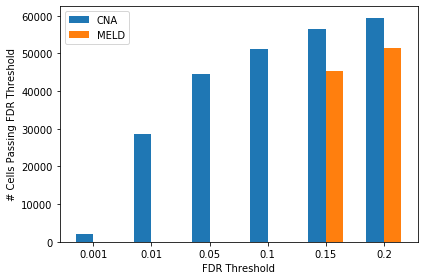

In [100]:
x = np.arange(len(plot_thresholds))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, CNA_cells_passing, width, label='CNA')
rects2 = ax.bar(x + width/2, MELD_cells_passing, width, label='MELD')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# Cells Passing FDR Threshold')
ax.set_xlabel('FDR Threshold')
ax.set_xticks(x)
ax.set_xticklabels(plot_thresholds)
ax.legend()

fig.tight_layout()
plt.show()

## Create Figure

performing association test
performing association test
performing association test
performing association test


/data/srlab/lrumker/MCSC_Project/cna/cna/cna/tools/_association.py:55: UserWarning: data supported use of 4 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  'Consider allowing more PCs by using the "ks" argument.').format(k))


performing association test


/PHShome/lar24/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


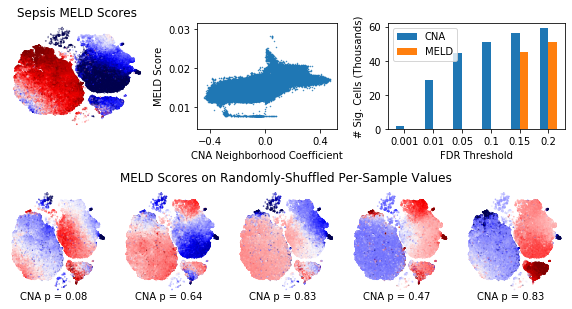

In [107]:
fig = plt.figure(figsize = (10,5))
gs = fig.add_gridspec(nrows=2, ncols=15, hspace = 0.55, wspace=0.5)
ax1 = fig.add_subplot(gs[0,0:4])
ax2 = fig.add_subplot(gs[0,5:9])
ax3 = fig.add_subplot(gs[0,10:15])
ax4 = fig.add_subplot(gs[1,0:3])
ax5 = fig.add_subplot(gs[1,3:6])
ax6 = fig.add_subplot(gs[1,6:9])
ax7 = fig.add_subplot(gs[1,9:12])
ax8 = fig.add_subplot(gs[1,12:15])


ax = ax1 # Scores on true sepsis values
val = sample_densities[sampleXmeta.index[true_pheno]].mean(axis=1) - sample_densities.mean(axis=1)
ax.scatter(d.obsm['X_tsne'][:,0], d.obsm['X_tsne'][:,1],
           alpha=0.5, c = val, cmap = "seismic", s=0.2, vmin=-color_scale_threshold, vmax=color_scale_threshold)
ax.set_title('Sepsis MELD Scores')
ax.axis('off')

ax = ax2 # Correlation between per-cell scores 
ax.scatter(cna_res['ncorrs'], sample_densities[sampleXmeta.index[true_pheno]].mean(axis=1), s=0.2)
ax.set_xticks([-0.4, 0, 0.4])
ax.set_xlabel('CNA Neighborhood Coefficient')
ax.set_ylabel('MELD Score')

ax = ax3
x = np.arange(len(plot_thresholds))  # the label locations
width = 0.3  # the width of the bars
rects1 = ax.bar(x - width/2, CNA_cells_passing/1000, width, label='CNA')
rects2 = ax.bar(x + width/2, MELD_cells_passing/1000, width, label='MELD')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# Sig. Cells (Thousands)')
ax.set_xlabel('FDR Threshold')
ax.set_xticks(x)
ax.set_xticklabels(plot_thresholds)
ax.legend()

np.random.seed(0)
for ax in [ax4, ax5, ax6, ax7, ax8]: 
    ix = np.argsort(np.random.randn(len(true_pheno)))
    null = true_pheno[ix]
    nullval = sample_densities[sampleXmeta.index[null]].mean(axis=1) - sample_densities.mean(axis=1)
    ax.scatter(d.obsm['X_tsne'][:,0], d.obsm['X_tsne'][:,1],
               alpha=0.5, c=nullval, cmap = "seismic", s=0.2, vmin=-color_scale_threshold, vmax=color_scale_threshold)
    nullres = cna.tl.association(d, null, local_test=False)
    ax.text(0.13, -0.05, 'CNA p = '+str(np.round(nullres.p,2)),
        transform=ax.transAxes, fontsize=10, color="black")
    ax.axis('off')
    
ax=ax6
ax.set_title('MELD Scores on Randomly-Shuffled Per-Sample Values') 
    
plt.tight_layout()
plt.savefig('../_figs/suppfig.meld.pdf')